# Can we read model 1 V-J gene use count matrix PCs to see which V genes matter?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import seaborn as sns
import joblib
import gc
import glob
from pathlib import Path
from matplotlib.ticker import MultipleLocator, PercentFormatter
import genetools
import shap

from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    map_cross_validation_split_strategy_to_default_target_obs_column,
)
from malid.trained_model_wrappers import RepertoireClassifier
from malid import config, helpers, io

In [2]:
def interpret(
    gene_locus: GeneLocus, target_obs_column: TargetObsColumnEnum, fold_id: int
):
    clf_rep = RepertoireClassifier(
        fold_id=fold_id,
        model_name="elasticnet_cv",
        fold_label_train="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        sample_weight_strategy=config.sample_weight_strategy,
    )
    train_count_matrix_columns = joblib.load(
        clf_rep.models_base_dir
        / f"{clf_rep.fold_label_train}_model.{clf_rep.fold_id}.{clf_rep.fold_label_train}.specimen_vj_gene_counts_columns_joblib"
    )

    isotypes = helpers.isotype_groups_kept[gene_locus]
    # # sanity check:
    # isotypes, clf_rep.steps[0][
    #     1
    # ].named_transformers_.keys(), train_count_matrix_columns.keys()

    for isotype in isotypes:
        print(isotype)
        pca_transformer = (
            clf_rep.steps[0][1]
            .named_transformers_[f"log1p-scale-PCA_{isotype}"]
            .steps[-1][1]
        )

        # PCs x VJ pairs
        components_df = pd.DataFrame(
            pca_transformer.components_, columns=train_count_matrix_columns[isotype]
        )
        # display(components_df)

        # most important features for first PC component
        n_top = 10
        # display(components_df.iloc[0].abs().sort_values(ascending=False).head(n=n_top))

        # V genes in there
        print(
            components_df.iloc[0]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        # second PC coponent, same thing:
        print(
            components_df.iloc[1]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        print()
        print("*" * 60)
        print()

    adata = io.load_fold_embeddings(
        fold_id=fold_id,
        fold_label="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        # Model 1 does not require the embedding .X, so take the fast path and just load .obs:
        load_obs_only=True,
    )
    featurized = clf_rep.featurize(adata)

    # or use clf_rep._inner[:-1] if we want scaling added:
    pca_transformer = clf_rep.steps[0][1]
    transformed = pd.DataFrame(
        pca_transformer.transform(featurized.X),
        index=featurized.X.index,
        columns=pca_transformer.get_feature_names_out(),
    )
    # Show model 1's top 2 PCs of V/J gene use counts for train fold specimens
    for isotype in helpers.isotype_groups_kept[gene_locus]:
        plot_df = pd.concat(
            [
                transformed[
                    [
                        f"log1p-scale-PCA_{isotype}__pca0",
                        f"log1p-scale-PCA_{isotype}__pca1",
                    ]
                ].rename(
                    columns={
                        f"log1p-scale-PCA_{isotype}__pca0": "PC1",
                        f"log1p-scale-PCA_{isotype}__pca1": "PC2",
                    }
                ),
                featurized.metadata[["disease", "study_name"]],
            ],
            axis=1,
        )
        plot_df["Disease and batch"] = (
            plot_df["disease"].astype(str) + " - " + plot_df["study_name"].astype(str)
        )
        fig, ax = plt.subplots()
        sns.scatterplot(
            data=plot_df, x="PC1", y="PC2", hue="Disease and batch", ax=ax, alpha=0.7
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        sns.despine(ax=ax)
        plt.title(f"{isotype} V-J gene use count PCA")

GeneLocus.BCR, TargetObsColumnEnum.disease, fold -1 (CrossValidationSplitStrategy.in_house_peak_disease_timepoints)
IGHG
Index(['IGHV4-b', 'IGHV1-2', 'IGHV3-23'], dtype='object', name='vgene_jgene')
Index(['IGHV1-18', 'IGHV1-46', 'IGHV3-9', 'IGHV1-24', 'IGHV3-30-3', 'IGHV1-8',
       'IGHV1-69', 'IGHV7-4-1'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHA
Index(['IGHV4-b', 'IGHV4-4', 'IGHV4-39'], dtype='object', name='vgene_jgene')
Index(['IGHV4-34', 'IGHV1-24', 'IGHV1-2', 'IGHV3-23', 'IGHV3-7', 'IGHV1-46',
       'IGHV1-8'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHD-M
Index(['IGHV4-39', 'IGHV3-48', 'IGHV1-3', 'IGHV4-b', 'IGHV1-46', 'IGHV4-61',
       'IGHV1-18'],
      dtype='object', name='vgene_jgene')
Index(['IGHV5-51', 'IGHV3-49', 'IGHV3-21', 'IGHV3-48', 'IGHV3-23', 'IGHV3-15',
       'IGHV1-69'],
      dtype='object', name='vgene_jgene')

************

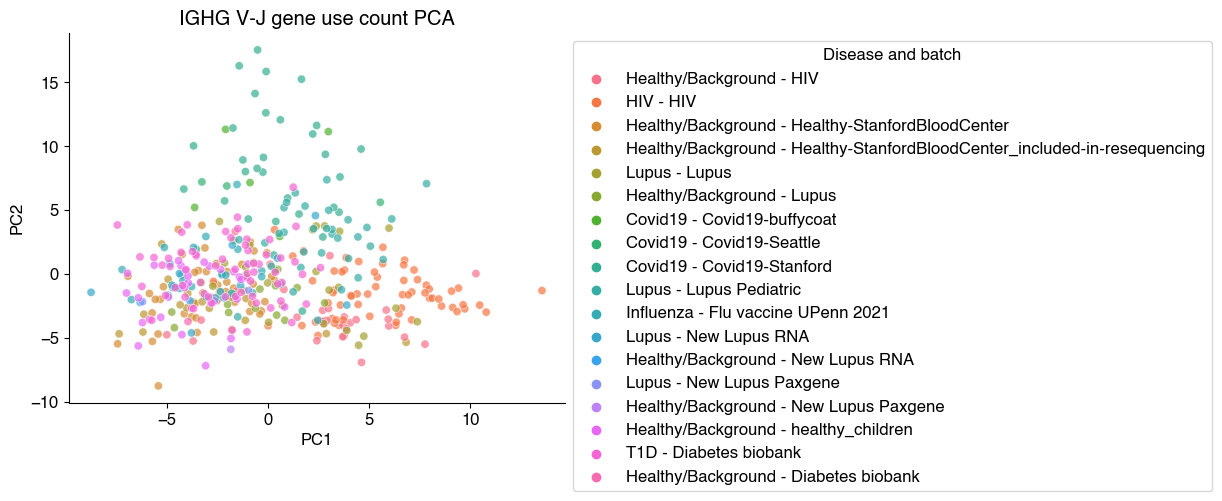

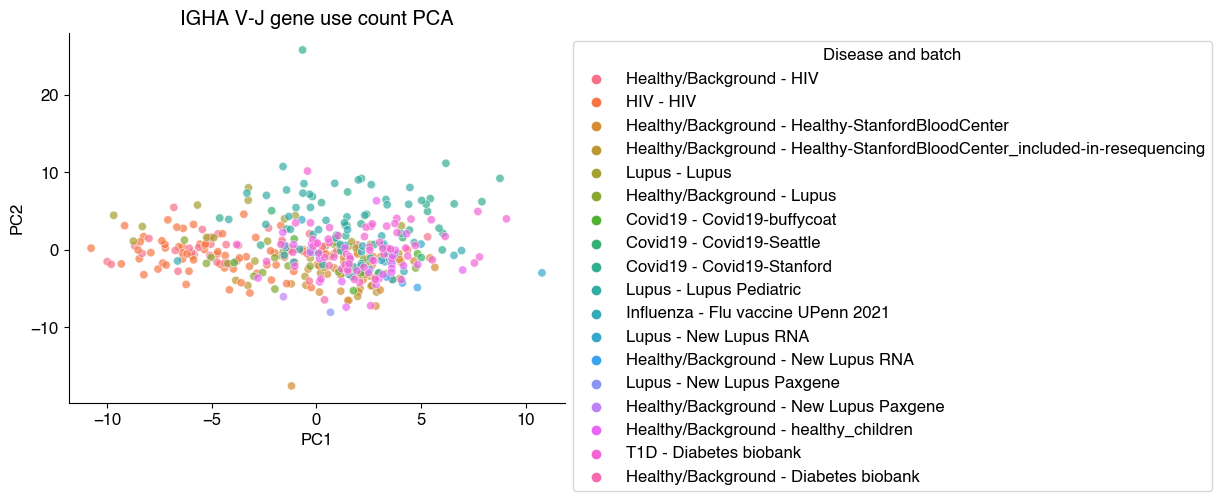

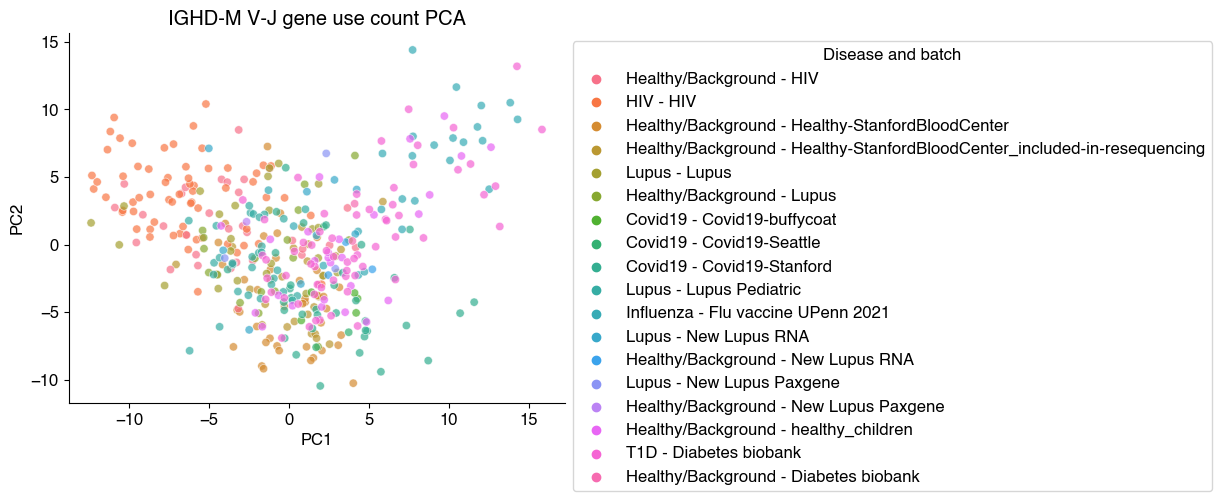

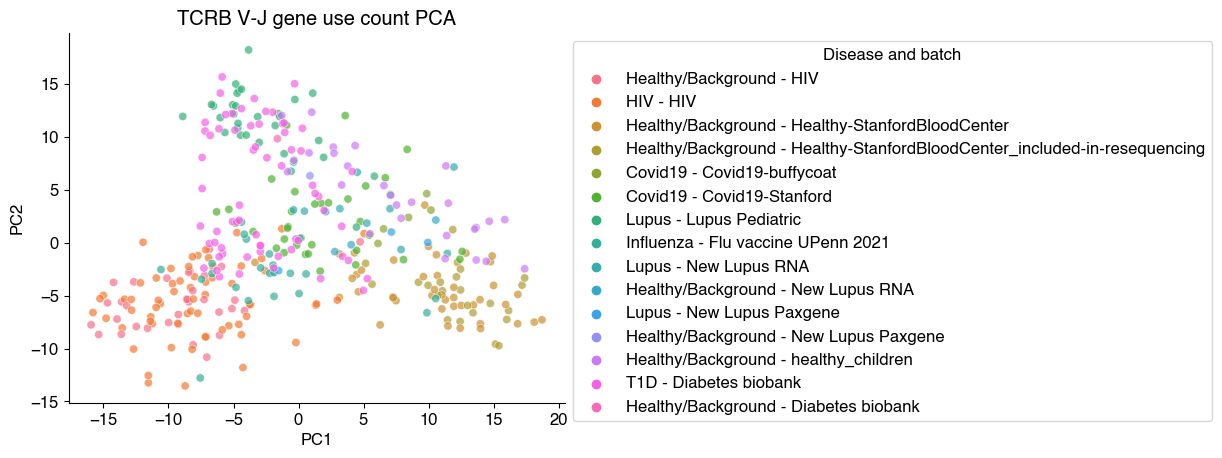

In [3]:
# Choose fold:
# Prefer global fold (fold -1), unless the cross validation split strategy is restricted to a single fold.
fold_id = 0 if config.cross_validation_split_strategy.value.is_single_fold_only else -1


# Choose classification target:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]

for gene_locus in config.gene_loci_used:
    print(
        f"{gene_locus}, {target_obs_column}, fold {fold_id} ({config.cross_validation_split_strategy})"
    )
    interpret(
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        fold_id=fold_id,
    )
    io.clear_cached_fold_embeddings()
    gc.collect()
    print()

# Another way to look at top signals

In [4]:
fold_id = 1
fold_label = "test"

In [5]:
adata_bcr = io.load_fold_embeddings(
    fold_id=fold_id,
    fold_label=fold_label,
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
    load_obs_only=True,
)
adata_bcr

ObsOnlyAnndata(obs=                    amplification_label    v_gene j_gene             disease  \
__null_dask_index__                                                            
9841                 M124-S014_cDNA_PCR  IGHV3-23  IGHJ4  Healthy/Background   
1                    M124-S014_cDNA_PCR  IGHV3-11  IGHJ4  Healthy/Background   
2                    M124-S014_cDNA_PCR   IGHV4-b  IGHJ3  Healthy/Background   
3                    M124-S014_cDNA_PCR  IGHV3-30  IGHJ5  Healthy/Background   
4                    M124-S014_cDNA_PCR  IGHV3-48  IGHJ6  Healthy/Background   
...                                 ...       ...    ...                 ...   
20546-68             M491-S167_cDNA_PCR  IGHV3-23  IGHJ5                 T1D   
20565-78             M491-S167_cDNA_PCR  IGHV3-23  IGHJ5                 T1D   
20597-64             M491-S167_cDNA_PCR   IGHV3-7  IGHJ4                 T1D   
20610-68             M491-S167_cDNA_PCR   IGHV3-h  IGHJ4                 T1D   
20689-85             

In [6]:
clf_bcr = RepertoireClassifier(
    fold_id=fold_id,
    model_name=config.metamodel_base_model_names.model_name_overall_repertoire_composition[
        GeneLocus.BCR
    ],
    fold_label_train="train_smaller",
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
)
clf_bcr

RepertoireClassifier: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log1p-scale-PCA_IGHG',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scale',
                                                                   StandardScalerThatPreservesInputType()),
                                                                  ('pca',
                                                                   PCA(n_components=15,
                                                                       random_state=0))]),
                                                  <sklearn.compose._column_t...
                 GlmnetLogitNetWrapper(alpha=0.25, class_weight='balanced', cut_point=1.0, fit_intercept=True, internal_cv=StratifiedGroupKFoldRequiresGroups(n_splits=5, random_state=0, shuffle=True), lambda_path=None, lower_limits=-inf, max_features=None, max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=5, random_state=0, require_cv_group_labels=True, scoring=<function GlmnetLogitNetWrapper.deviance_scorer at 0x7f5bcb054430>, standardize=False, tol=1e-07, upper_limits=inf, use_lambda_1se=False, verbose=True))])

In [7]:
clf_bcr.model_name

'elasticnet_cv0.25'

In [8]:
featurized_data_bcr = clf_bcr.featurize(adata_bcr)
featurized_data_bcr.X

,v_mut_median_per_specimen:IGHG,v_sequence_is_mutated:IGHG,v_mut_median_per_specimen:IGHA,v_sequence_is_mutated:IGHA,v_mut_median_per_specimen:IGHD-M,v_sequence_is_mutated:IGHD-M,IGHG:pca_IGHV1-18|IGHJ1:IGHG,IGHG:pca_IGHV1-18|IGHJ2:IGHG,IGHG:pca_IGHV1-18|IGHJ3:IGHG,IGHG:pca_IGHV1-18|IGHJ4:IGHG,...,IGHD-M:pca_IGHV6-1|IGHJ3:IGHD-M,IGHD-M:pca_IGHV6-1|IGHJ4:IGHD-M,IGHD-M:pca_IGHV6-1|IGHJ5:IGHD-M,IGHD-M:pca_IGHV6-1|IGHJ6:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ1:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ2:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ3:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ4:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ5:IGHD-M,IGHD-M:pca_IGHV7-4-1|IGHJ6:IGHD-M
specimen_label,,,,,,,,,,,,,,,,,,,,,
M124-S014,0.088106,0.979316,0.099567,0.980505,0.030303,1.0,0.001200,0.000400,0.005801,0.015803,...,0.000157,0.000708,0.000157,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M111-S055,0.044053,0.890187,0.078603,0.987527,0.026432,1.0,0.000880,0.001100,0.004729,0.018256,...,0.000291,0.000726,0.000639,0.000436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M124-S070,0.039823,0.870484,0.070485,0.911017,0.022026,1.0,0.000462,0.000693,0.005543,0.019400,...,0.000400,0.001332,0.001465,0.001465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M124-S012,0.064378,0.944152,0.061135,0.923056,0.030568,1.0,0.001209,0.000907,0.006044,0.024176,...,0.000446,0.004465,0.001722,0.000957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M111-S042,0.088106,0.978591,0.089686,0.974057,0.038961,1.0,0.002104,0.001202,0.005712,0.016835,...,0.000858,0.003111,0.000536,0.000429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M491-S133,0.069264,0.939565,0.066372,0.937901,0.034335,1.0,0.000208,0.000832,0.003122,0.015609,...,0.001458,0.005345,0.001944,0.001805,0.000069,0.000069,0.000972,0.003540,0.000833,0.001527
M491-S141,0.078261,0.986674,0.074236,0.977044,0.034783,1.0,0.000000,0.001151,0.000000,0.018998,...,0.001073,0.006225,0.001932,0.002683,0.000000,0.000000,0.000000,0.000215,0.000000,0.000107
M491-S147,0.073593,0.965400,0.078947,0.968093,0.030702,1.0,0.001758,0.000000,0.001758,0.019930,...,0.000452,0.002035,0.000791,0.000904,0.000000,0.000565,0.000678,0.004409,0.000791,0.001922


In [9]:
transformed_X_bcr = clf_bcr._inner[:-1].transform(featurized_data_bcr.X)
transformed_X_bcr

array([[ 1.07554497, -0.89663519, -0.75618464, ...,  0.47768128,
         0.31205381,  0.        ],
       [ 1.71739838,  0.29048524, -0.49912749, ...,  0.58443767,
        -0.61727535,  0.        ],
       [ 1.50370396,  0.22002224, -0.19785174, ..., -0.57886441,
        -1.67478785,  0.        ],
       ...,
       [ 0.01317937, -0.63064185, -0.67592182, ...,  0.28896109,
         0.40776965,  0.        ],
       [-0.40548569,  0.16856335,  0.59533841, ...,  0.2392995 ,
         0.44023714,  0.        ],
       [-0.42470647, -0.3835671 ,  0.12792361, ...,  0.27183432,
        -0.72714678,  0.        ]])

In [10]:
featurized_data_bcr.X.shape, transformed_X_bcr.shape

((210, 726), (210, 51))

In [11]:
transformed_X_bcr = pd.DataFrame(
    transformed_X_bcr,
    index=featurized_data_bcr.X.index,
    columns=clf_bcr.named_steps["columntransformer"].get_feature_names_out(),
)

In [12]:
transformed_X_bcr

,log1p-scale-PCA_IGHG__pca0,log1p-scale-PCA_IGHG__pca1,log1p-scale-PCA_IGHG__pca2,log1p-scale-PCA_IGHG__pca3,log1p-scale-PCA_IGHG__pca4,log1p-scale-PCA_IGHG__pca5,log1p-scale-PCA_IGHG__pca6,log1p-scale-PCA_IGHG__pca7,log1p-scale-PCA_IGHG__pca8,log1p-scale-PCA_IGHG__pca9,...,log1p-scale-PCA_IGHD-M__pca11,log1p-scale-PCA_IGHD-M__pca12,log1p-scale-PCA_IGHD-M__pca13,log1p-scale-PCA_IGHD-M__pca14,remainder__v_mut_median_per_specimen:IGHG,remainder__v_sequence_is_mutated:IGHG,remainder__v_mut_median_per_specimen:IGHA,remainder__v_sequence_is_mutated:IGHA,remainder__v_mut_median_per_specimen:IGHD-M,remainder__v_sequence_is_mutated:IGHD-M
specimen_label,,,,,,,,,,,,,,,,,,,,,
M124-S014,1.075545,-0.896635,-0.756185,-0.009078,-1.245606,0.605216,0.512749,-0.238034,0.149675,0.477089,...,0.131691,0.828009,-0.419606,0.463320,1.151754,0.598137,1.825036,0.477681,0.312054,0.0
M111-S055,1.717398,0.290485,-0.499127,-0.455563,0.980917,-1.594615,0.610980,-0.539665,0.377690,-0.342563,...,-1.129533,0.789632,-0.103492,-1.145566,-0.893545,-0.040049,0.367402,0.584438,-0.617275,0.0
M124-S070,1.503704,0.220022,-0.197852,0.166940,0.429282,-1.323220,1.074585,-0.253250,-0.340694,-0.042624,...,-0.097973,1.745153,0.553607,-1.332729,-1.089930,-0.181129,-0.197035,-0.578864,-1.674788,0.0
M124-S012,-0.399223,-0.739061,0.155138,0.620605,-0.362865,-1.000589,-0.513871,-0.053109,-0.382898,0.345831,...,0.616189,0.228414,0.921938,-1.532982,0.050102,0.346355,-0.847074,-0.395818,0.375586,0.0
M111-S042,1.612655,-0.302353,-2.088621,0.586082,-0.146873,-0.165748,-0.175684,-0.631400,0.361853,-0.125179,...,0.612069,-0.260748,-0.427116,-1.187696,1.151754,0.592952,1.138022,0.379637,2.390455,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M491-S133,-0.793360,-0.198088,0.545585,-0.290796,0.499539,0.926520,0.518426,0.139349,0.071576,0.005994,...,0.994808,-0.209360,0.212588,-2.381120,0.276968,0.313510,-0.483000,-0.170103,1.279893,0.0
M491-S141,-0.163331,-1.166265,0.433970,-0.532006,0.129928,-1.941852,-0.355471,-0.985983,0.195125,0.925906,...,1.802455,-0.123360,0.063110,-1.294623,0.694674,0.650825,0.063783,0.425059,1.387401,0.0
M491-S147,0.013179,-0.630642,-0.675922,-0.188565,-0.783795,-0.030114,1.040653,0.390306,0.028176,-0.389154,...,-0.575211,-0.430309,-1.194551,0.196852,0.477956,0.498496,0.391372,0.288961,0.407770,0.0


In [13]:
explainer_bcr = shap.LinearExplainer(
    (clf_bcr.steps[-1][1].coef_, clf_bcr.steps[-1][1].intercept_),
    transformed_X_bcr,
)

In [14]:
shap_values_bcr = explainer_bcr.shap_values(X=transformed_X_bcr)
len(shap_values_bcr)

6

In [15]:
shap_values_bcr[0].shape

(210, 51)

In [16]:
transformed_X_bcr.shape, clf_bcr.classes_.shape

((210, 51), (6,))

In [17]:
clf_bcr.classes_

array(['Covid19', 'HIV', 'Healthy/Background', 'Influenza', 'Lupus',
       'T1D'], dtype=object)

In [25]:
# is featurized_data_bcr.X scaled to sum to 1 per isotype? yes:
assert np.allclose(
    featurized_data_bcr.X[
        featurized_data_bcr.X.columns[
            featurized_data_bcr.X.columns.str.startswith("IGHD-M:pca")
        ]
    ].sum(axis=1),
    1,
)
assert np.allclose(
    featurized_data_bcr.X[
        featurized_data_bcr.X.columns[
            featurized_data_bcr.X.columns.str.startswith("IGHG:pca")
        ]
    ].sum(axis=1),
    1,
)
assert np.allclose(
    featurized_data_bcr.X[
        featurized_data_bcr.X.columns[
            featurized_data_bcr.X.columns.str.startswith("IGHA:pca")
        ]
    ].sum(axis=1),
    1,
)

In [30]:
# Extract T1D class coefficients
class_id = np.where(clf_bcr.classes_ == "T1D")[0][0]
coefs_t1d = pd.Series(
    clf_bcr.steps[-1][1].coef_[class_id], index=transformed_X_bcr.columns
).sort_values()
coefs_t1d

remainder__v_sequence_is_mutated:IGHA         -1.107010
log1p-scale-PCA_IGHG__pca1                    -0.621359
log1p-scale-PCA_IGHA__pca10                   -0.603442
log1p-scale-PCA_IGHA__pca9                    -0.557052
remainder__v_mut_median_per_specimen:IGHD-M   -0.401125
log1p-scale-PCA_IGHG__pca12                   -0.386688
log1p-scale-PCA_IGHD-M__pca1                  -0.384015
log1p-scale-PCA_IGHG__pca4                    -0.355530
log1p-scale-PCA_IGHD-M__pca14                 -0.242551
log1p-scale-PCA_IGHD-M__pca12                 -0.211882
log1p-scale-PCA_IGHD-M__pca9                  -0.202429
log1p-scale-PCA_IGHA__pca13                   -0.189491
log1p-scale-PCA_IGHA__pca4                    -0.148803
log1p-scale-PCA_IGHD-M__pca7                  -0.122538
log1p-scale-PCA_IGHD-M__pca4                  -0.116755
log1p-scale-PCA_IGHD-M__pca6                  -0.083255
remainder__v_mut_median_per_specimen:IGHA     -0.042640
log1p-scale-PCA_IGHA__pca12                   -0

In [26]:
# Find a top T1D feature based on average SHAP values over positive test-set items
class_id = np.where(clf_bcr.classes_ == "T1D")[0][0]
shap_sorted = (
    pd.DataFrame(
        shap_values_bcr[class_id],
        index=featurized_data_bcr.sample_names,
        columns=transformed_X_bcr.columns,
    )
    .loc[featurized_data_bcr.y == "T1D"]
    .mean(axis=0)
    .sort_values()
)
shap_sorted

log1p-scale-PCA_IGHD-M__pca1                  -0.132392
log1p-scale-PCA_IGHG__pca7                    -0.051892
log1p-scale-PCA_IGHA__pca1                    -0.042392
log1p-scale-PCA_IGHD-M__pca9                  -0.029535
log1p-scale-PCA_IGHG__pca3                    -0.019386
log1p-scale-PCA_IGHA__pca13                   -0.015714
log1p-scale-PCA_IGHA__pca12                   -0.011860
log1p-scale-PCA_IGHG__pca12                   -0.010752
log1p-scale-PCA_IGHD-M__pca2                  -0.010677
log1p-scale-PCA_IGHA__pca11                   -0.005098
log1p-scale-PCA_IGHD-M__pca12                 -0.004464
log1p-scale-PCA_IGHG__pca10                    0.000000
log1p-scale-PCA_IGHG__pca11                    0.000000
log1p-scale-PCA_IGHG__pca13                    0.000000
log1p-scale-PCA_IGHG__pca14                    0.000000
log1p-scale-PCA_IGHD-M__pca13                  0.000000
log1p-scale-PCA_IGHG__pca2                     0.000000
log1p-scale-PCA_IGHA__pca3                     0

In [27]:
# Get top feature
feat = shap_sorted.index[-1]
feat

'log1p-scale-PCA_IGHD-M__pca0'

In [28]:
# Get loadings: how much each original count feature contributes to each PC
# each row is a top PC
# each column corresponds to an original count feature
prefix = feat.split("__pca")[0]  # e.g. "log1p-scale-PCA_IGHG"
loadings = pd.DataFrame(
    clf_bcr.steps[0][1].named_transformers_[prefix].steps[-1][1].components_,
    columns=clf_bcr.steps[0][1].named_transformers_[prefix].feature_names_in_,
)
# name it consistently
loadings.index = [f"{prefix}__pca{i}" for i in loadings.index]

In [31]:
# look at top 10 contributors
# We need to decide to look at top positive or top negative loadings - based on the coefficient for this feature:
report_positive_loading = coefs_t1d[feat] > 0
print(feat, coefs_t1d[feat], report_positive_loading)
# If the top feature is a PCA feature:
# Report the top V genes with positive loadings for that PC, meaning their presence drives the PC up.
# That's if the feature has a positive coefficient in the model.
#
# Or, if the PC feature has a negative coefficient in the model, report the V genes with negative loadings, meaning increased gene presence drives the PC down and then the negative coefficient translates it into positive model impact.
# (In other words, for PCA features with negative coefficients, it makes sense to look at the negative loadings, because a V gene with negative loading means a higher V gene presence i.e. count value pushes the PC lower)
#
# This logic only applies to PC features; if we had a v_mut feature with a negative coefficient, there's no interpreting that as leading to positive predictions.

log1p-scale-PCA_IGHD-M__pca0 0.4281638178592481 True


In [32]:
top_contributors = (
    loadings.loc[feat].sort_values(ascending=report_positive_loading).tail(n=10)
)
# extract V gene names
top_contributor_v_genes = top_contributors.index.str.split("|").str[0].unique().tolist()

In [33]:
print(feat)
print()
print(top_contributors)
print()
print(top_contributor_v_genes)

log1p-scale-PCA_IGHD-M__pca0

IGHD-M:pca_IGHV2-5|IGHJ6:IGHD-M     0.096805
IGHD-M:pca_IGHV3-13|IGHJ3:IGHD-M    0.099070
IGHD-M:pca_IGHV1-46|IGHJ4:IGHD-M    0.099273
IGHD-M:pca_IGHV3-48|IGHJ6:IGHD-M    0.103843
IGHD-M:pca_IGHV1-18|IGHJ6:IGHD-M    0.112854
IGHD-M:pca_IGHV3-13|IGHJ4:IGHD-M    0.114641
IGHD-M:pca_IGHV3-11|IGHJ6:IGHD-M    0.119390
IGHD-M:pca_IGHV3-13|IGHJ6:IGHD-M    0.119425
IGHD-M:pca_IGHV1-3|IGHJ6:IGHD-M     0.119731
IGHD-M:pca_IGHV1-46|IGHJ6:IGHD-M    0.126068
Name: log1p-scale-PCA_IGHD-M__pca0, dtype: float64

['IGHD-M:pca_IGHV2-5', 'IGHD-M:pca_IGHV3-13', 'IGHD-M:pca_IGHV1-46', 'IGHD-M:pca_IGHV3-48', 'IGHD-M:pca_IGHV1-18', 'IGHD-M:pca_IGHV3-11', 'IGHD-M:pca_IGHV1-3']


In [34]:
# Plot those V genes' proportions in T1D vs not T1D.
# If we want to look at V gene level, sum up all the proportions by V gene (within each isotype). because featurized_data_bcr.X is scaled to sum to 1 per isotype

In [35]:
feat = top_contributors.index[-1]
feat

'IGHD-M:pca_IGHV1-46|IGHJ6:IGHD-M'

In [36]:
feat = feat.split("|")[0]
feat

'IGHD-M:pca_IGHV1-46'

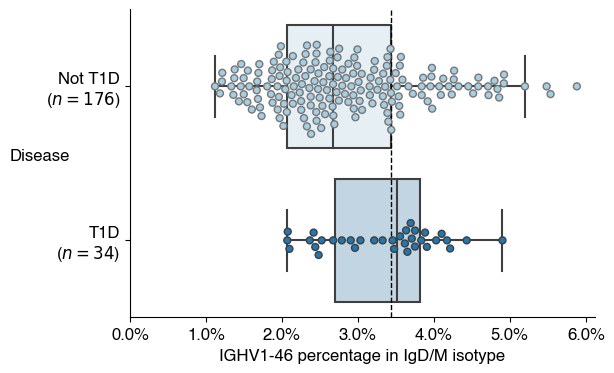

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_df = pd.concat(
    [
        featurized_data_bcr.X[
            featurized_data_bcr.X.columns[
                featurized_data_bcr.X.columns.str.startswith(feat + "|")
            ]
        ]
        .sum(axis=1)
        .rename(feat),
        (featurized_data_bcr.y == "T1D").map({True: "T1D", False: "Not T1D"}),
    ],
    axis=1,
)
order = ["Not T1D", "T1D"]
ax = sns.boxplot(
    data=plot_df,
    x=feat,
    y="disease",
    order=order,
    # Disable outlier markers:
    fliersize=0,
    palette=sns.color_palette("Paired")[:2],
    zorder=1,
    ax=ax,
)
for patch in ax.patches:
    # Set boxplot alpha transparency: https://github.com/mwaskom/seaborn/issues/979#issuecomment-1144615001
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.3))

np.random.seed(123)  # seed for swarmplot jitter
sns.swarmplot(
    data=plot_df,
    x=feat,
    y="disease",
    order=order,
    hue="disease",
    legend=None,
    linewidth=1,
    edgecolor="gray",
    palette=sns.color_palette("Paired")[:2],
    ax=ax,
    zorder=20,
)

plt.axvline(
    x=plot_df[plot_df["disease"] == "Not T1D"][feat].describe().loc["75%"],
    linestyle="dashed",
    zorder=10,
    linewidth=1,
    # color=sns.color_palette("Paired")[0],
    color="k",
)

# e.g. 'IGHD-M:pca_IGHV1-46' -> ['IGHD-M', 'IGHV1-46']
feat_name_parts = feat.split(":pca_")

# e.g. "IGHV1-46 percentage in IgD/M isotype"
plt.xlabel(
    f"{feat_name_parts[1]} percentage in {helpers.isotype_friendly_names[feat_name_parts[0]]} isotype"
)

ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(
    0,
)
plt.ylabel("Disease", rotation=0)
ax.set_yticklabels(
    genetools.plots.add_sample_size_to_labels(
        labels=ax.get_yticklabels(),
        data=plot_df,
        hue_key="disease",
    )
)
sns.despine(ax=ax)
genetools.plots.savefig(
    fig,
    clf_bcr.output_base_dir
    / f"{clf_bcr.fold_label_train}_model.top_signal.fold_{clf_bcr.fold_id}.{fold_label}.{clf_bcr.model_name}.png",
    dpi=300,
)